In [1]:
from os.path import join
import torch
from matplotlib import pyplot as plt, colors
from scipy.io import loadmat
import numpy as np
import pandas as pd
import mne
from mne.datasets import eegbci
from mne.io import read_raw_edf
from mne.viz import plot_topomap, plot_alignment
from mayavi import mlab
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)
mlab.init_notebook("x3d", 800, 600)

Notebook initialized with x3d backend.


In [2]:
min_confidence = 0.01 # minimum confidence to keep a prediction (0: no confidence, 1: full confidence)
model_dir = "../transformer/models/caffeine" # path to the log directory of the model checkpoint

In [3]:
# load extracted attention weights and metadata
(attn, confidence, pred, labels, stages, subjects, hparams,
 condition_mapping, stage_mapping, subject_mapping) = torch.load(join(model_dir, "attention.pt"))

# mask out attention weights of incorrect low-confidence predictions
confidence_mask = confidence >= min_confidence
correct_mask = pred == labels
attn_mask = confidence_mask & correct_mask
attn = attn[attn_mask]

# create a mask where condition 0 is true and condition 1 is false
condition_mask = labels[attn_mask] == 0

print(f"loaded attention weights extracted from {len(subjects.unique())} "
      f"subjects and {len(stages.unique())} stages")

n_cond0 = condition_mask.sum().item()
print(f"got {n_cond0} {condition_mapping[0]} and "
      f"{len(condition_mask) - n_cond0} {condition_mapping[1]} attention maps")

print(f"validation accuracy: {correct_mask.float().mean().item():.2%}")

loaded attention weights extracted from 6 subjects and 4 stages
got 3299 CAF and 4974 PLAC attention maps
validation accuracy: 61.62%


In [4]:
def confusion_matrix(prediction, ground_truth):
    # compute the confusion matrix
    cond0_mask = ground_truth == 0
    confusion_mat = np.zeros((2, 2))
    confusion_mat[0,0] = (prediction[cond0_mask] == ground_truth[cond0_mask]).sum().item()
    confusion_mat[1,0] = (prediction[cond0_mask] != ground_truth[cond0_mask]).sum().item()
    confusion_mat[1,1] = (prediction[~cond0_mask] == ground_truth[~cond0_mask]).sum().item()
    confusion_mat[0,1] = (prediction[~cond0_mask] != ground_truth[~cond0_mask]).sum().item()
    confusion_mat /= confusion_mat.sum()
    fmt = lambda x: f"{x:.2%}"
    return pd.DataFrame(data=confusion_mat, index=condition_mapping, columns=condition_mapping).applymap(fmt)

confusion_matrix(pred, labels)

,CAF,PLAC
CAF,24.81%,11.80%
PLAC,26.58%,36.81%


# load metadata

In [5]:
if hparams.num_channels == 20:
    ###############################################
    ################# 20 channels #################
    ###############################################
    # set the montage type
    montage_type = "standard_1020"
    # define channel names
    channels = ['Fp1', 'Fp2', 'F3', 'F4', 'F7', 'F8', 'C3', 'C4', 'P3', 'P4',
                'O1', 'O2', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz', 'Oz']
    # load EEG sensor positions to be used in the topomaps
    sensor_pos = loadmat(join("../data", 'Coo_caf'))['Cor'].T
    sensor_pos = np.array([sensor_pos[1], sensor_pos[0]]).T
elif hparams.num_channels == 64:
    ###############################################
    ################# 64 channels #################
    ###############################################
    # set the montage type
    montage_type = "standard_1005"
    # define channel names
    def standardize(ch_names):
        names = []
        for name in ch_names:
            std_name = name.strip(".")
            std_name = std_name.upper()
            if std_name.endswith("Z"):
                std_name = std_name[:-1] + "z"
            if std_name.startswith("FP"):
                std_name = "Fp" + std_name[2:]
            names.append(std_name)
        return names

    channels = standardize(read_raw_edf(eegbci.load_data(1, 1)[0]).ch_names)
    print("\nreference channels:", dict(T9=channels.index("T9"),
                                        T10=channels.index("T10"),
                                        Iz=channels.index("Iz")))
    # load EEG sensor positions to be used in the topomaps
    layout = mne.channels.read_layout("EEG1005")
    sensor_pos = np.empty((hparams.num_channels, 2))
    for i, name in enumerate(channels):
        idx = layout.names.index(name)
        sensor_pos[i] = layout.pos[idx][:2]

In [6]:
# remove channels that are listed in the model's ignore_channel list
num_channels = hparams.num_channels
if len(hparams.ignore_channels) > 0:
    print("dropping channels", ", ".join(channels[i] for i in hparams.ignore_channels))
    channels = [ch for i, ch in enumerate(channels) if i not in hparams.ignore_channels]
    num_channels = len(channels)
    sensor_pos = np.array([p for i, p in enumerate(sensor_pos) if i not in hparams.ignore_channels])

# plotting functions

In [7]:
def colorbar(vmin, vmax, cmap, ax=None, cax=None):
    norm = colors.Normalize(vmin=vmin,vmax=vmax)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, ax=ax, cax=cax)

In [8]:
def temporal_topomaps(attn_weights, mask, title="", cmap="Reds"):
    axes = plt.subplots(2, hparams.num_tokens + 1, figsize=(15, 5),
                        gridspec_kw=dict(width_ratios=[1] * hparams.num_tokens + [0.1]))[1]
    plt.suptitle(title, fontsize=20, y=1.1)

    attn0 = attn_weights[mask].mean(dim=0)
    attn1 = attn_weights[~mask].mean(dim=0)
    
    # condition 0
    vmin, vmax = attn0.min(), attn0.max()
    axes[0,0].set_ylabel(condition_mapping[0], fontsize=15)
    for i in range(attn0.size(0)):
        plot_topomap(attn0[i], sensor_pos, contours=False, axes=axes[0,i], show=False,
                     vmin=vmin, vmax=vmax, cmap=cmap)
        axes[0,i].set_title(f"t={i}", fontsize=15)
    colorbar(vmin, vmax, cmap, cax=axes[0,-1])

    # condition 1
    vmin, vmax = attn1.min(), attn1.max()
    axes[1,0].set_ylabel(condition_mapping[1], fontsize=15)
    for i in range(attn1.size(0)):
        plot_topomap(attn1[i], sensor_pos, contours=False, axes=axes[1,i], show=False,
                     vmin=vmin, vmax=vmax, cmap=cmap)
    colorbar(vmin, vmax, cmap, cax=axes[1,-1])
    plt.show()

In [9]:
def temporal_avg_topomaps(attn_weights, mask, title="", cmap="Reds"):
    axes = plt.subplots(ncols=2, figsize=(10, 4))[1]
    plt.suptitle(title, fontsize=20, y=1.15)

    attn0 = attn_weights[mask].mean(dim=(0, 1))
    attn1 = attn_weights[~mask].mean(dim=(0, 1))

    # condition 0
    axes[0].set_title(condition_mapping[0], fontsize=15)
    vmin, vmax = attn0.min(), attn0.max()
    plot_topomap(attn0, sensor_pos, contours=False, axes=axes[0], show=False,
                 vmin=vmin, vmax=vmax, cmap=cmap)
    colorbar(vmin, vmax, cmap, axes[0])
    # condition 1
    axes[1].set_title(condition_mapping[1], fontsize=15)
    vmin, vmax = attn1.min(), attn1.max()
    plot_topomap(attn1, sensor_pos, contours=False, axes=axes[1], show=False,
                 vmin=vmin, vmax=vmax, cmap=cmap)
    colorbar(vmin, vmax, cmap, axes[1])
    plt.show()

In [10]:
def diff_topomap(attn_weights, mask):
    diff = attn_weights[mask].mean(dim=(0, 1)) - attn_weights[~mask].mean(dim=(0, 1))

    vmin, vmax = diff.min(), diff.max()
    absmax = max(abs(vmin), abs(vmax))

    plt.title(f"{condition_mapping[0]} - {condition_mapping[1]}", fontsize=15)
    plot_topomap(diff, sensor_pos, contours=False, vmin=-absmax, vmax=absmax, cmap="coolwarm", show=False)
    colorbar(-absmax, absmax, "coolwarm")
    plt.show()

# attention towards class token
This computes the attention towards the class token from the perspective of every channel and temporal token, which is an estimate of how much information each channel/token contributes towards the final prediction.

In [11]:
class_attn = attn[:,0,1:]
class_attn /= class_attn.max(dim=1, keepdims=True).values
class_attn = class_attn.reshape(-1, hparams.num_tokens, num_channels)

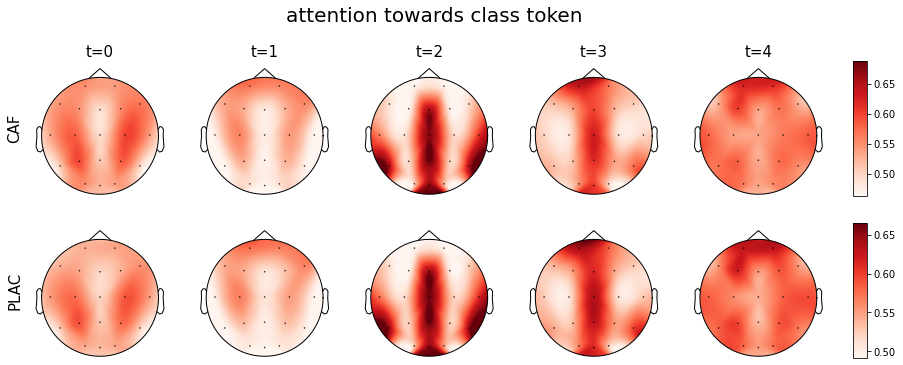

In [12]:
temporal_topomaps(class_attn, condition_mask, "attention towards class token")

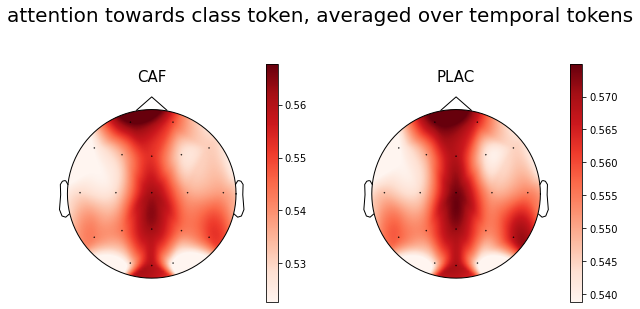

In [13]:
temporal_avg_topomaps(class_attn, condition_mask, "attention towards class token, averaged over temporal tokens")

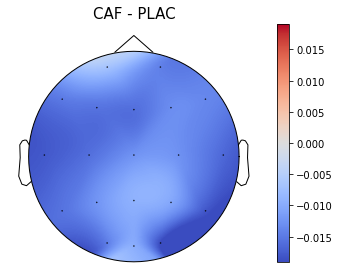

In [14]:
diff_topomap(class_attn, condition_mask)

# inter-channel attention
Here we compute the total attention that each channel/token receives throughout the network, which gives an estimate of the importance for each feature while coming up with the prediction. The results seem to be almost identical to the attention towards the class token.

In [15]:
channel_attn = attn[:,1:,1:].mean(dim=1)
channel_attn /= channel_attn.max(dim=1, keepdims=True).values
channel_attn = channel_attn.reshape(-1, hparams.num_tokens, num_channels)

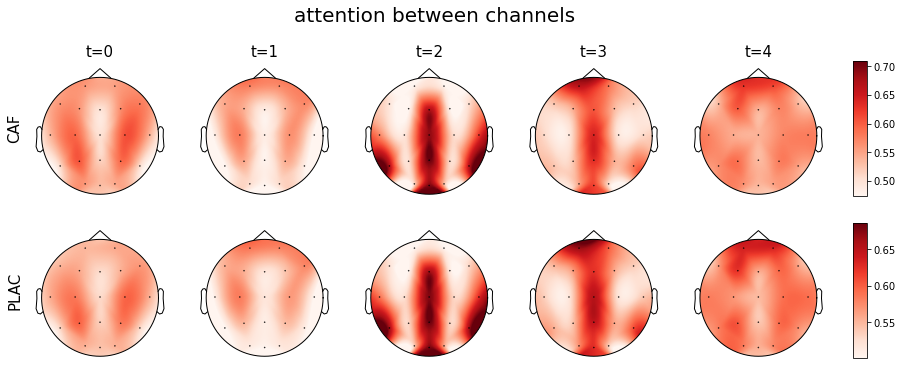

In [16]:
temporal_topomaps(channel_attn, condition_mask, "attention between channels")

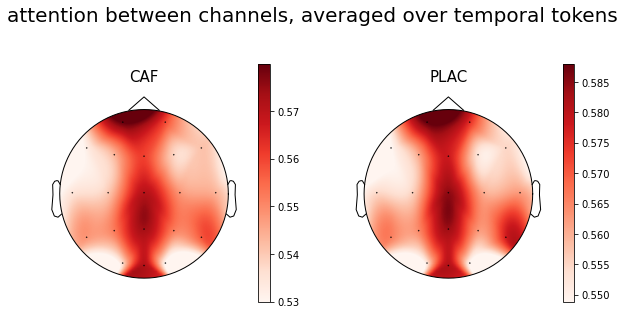

In [17]:
temporal_avg_topomaps(channel_attn, condition_mask, "attention between channels, averaged over temporal tokens")

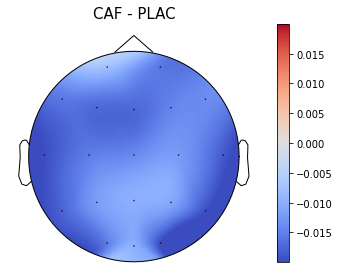

In [18]:
diff_topomap(channel_attn, condition_mask)

# 3D attention plots
These plots show three-dimensional connections of the top k attention scores averaged across temporal tokens. Line width and transparency indicates the magnitude of the attention weight (wider, more opaque lines correspond to larger attention weights). Lines are colored with a gradient from blue to red, indicating the direction of the attention weight with attention being directed from blue towards red. The directionality of attention corresponds to a flow of information.

In [19]:
# load 3D channel positions for a certain montage type
montage = mne.channels.make_standard_montage(montage_type)
info = mne.create_info(channels, 160, ch_types="eeg", montage=montage, verbose="error")

In [20]:
def topk(val, k):
    # compute indices of top k values inside an n-dimensional tensor
    if k == -1:
        k = val.numel()
    v, i = torch.topk(val.flatten(), k)
    return np.array(np.unravel_index(i.numpy(), val.shape)).T

def quadratic_bezier(start, end, modifier, n_steps=10):
    # generate n_steps points along a quadratic bezier curve
    points = []
    for alpha in np.linspace(0, 1, n_steps):
        p1 = alpha * modifier + (1 - alpha) * start
        p2 = alpha * end + (1 - alpha) * modifier
        p = alpha * p2 + (1 - alpha) * p1
        points.append(p)
    return np.array(points)

def cubic_bezier(start, end, modifiers, n_steps=10):
    # generate n_steps points along a cubic bezier curve
    points = []
    for alpha in np.linspace(0, 1, n_steps):
        p1 = alpha * modifiers[0] + (1 - alpha) * start
        p2 = alpha * modifiers[1] + (1 - alpha) * modifiers[0]
        p3 = alpha * end + (1 - alpha) * modifiers[1]
        p4 = alpha * p2 + (1 - alpha) * p1
        p5 = alpha * p3 + (1 - alpha) * p2
        p = alpha * p5 + (1 - alpha) * p4
        points.append(p)
    return np.array(points)

def plot_3d(condition, num_weights=100, n_bezier_steps=10):
    # plot spheres at 3D channel locations
    fig = plot_alignment(info, dig=False, eeg=True, surfaces=[], coord_frame='head')
    mlab.figure(figure=fig, bgcolor=(0.2, 0.2, 0.2))
    # extract transformed channel locations
    ch_positions = fig.children[0].data.points

    print(f"attention weights for class \"{condition_mapping[condition]}\"")
    mask = condition_mask
    if condition == 0:
        mask = ~condition_mask

    # average weights across the batch dimension and discard class token
    attn_mat = attn[mask].mean(dim=0)[1:,1:]
    # average temporal tokens to get an n_channels x n_channels attention matrix
    attn_mat = attn_mat.reshape(num_channels, hparams.num_tokens,
                                hparams.num_tokens, num_channels)
    attn_mat = attn_mat.mean(dim=-2).mean(dim=1)

    # extract indices of top k attention weights and normalize to [0, 1]
    topk_idxs = topk(attn_mat, num_weights)
    topk_attn = attn_mat[topk_idxs.T]
    topk_attn = (topk_attn - topk_attn.min()) / (topk_attn.max() - topk_attn.min())

    # create a mapping from channel names to transformed 3D locations
    info_channels = [channel["ch_name"] for channel in info["chs"] if channel["ch_name"] in channels]
    pos_mapping = {name: ch_positions[info_channels.index(name)] for name in channels}
    positions_arr = np.array(list(pos_mapping.values()))

    # iterate over top k attention weights
    for (i, j), attn_strength in zip(topk_idxs, topk_attn):
        # start and end location of the line
        from_pos = np.array(pos_mapping[channels[i]])
        to_pos = np.array(pos_mapping[channels[j]])
        center_of_mass = np.array(list(pos_mapping.values())).mean(axis=0)
        
        if i == j:
            # 
            vec = from_pos - center_of_mass
            vec /= np.linalg.norm(vec) * 40
            closest_idx = np.linalg.norm(positions_arr - from_pos, axis=1).argsort()[1]
            dir_vec = from_pos - positions_arr[closest_idx]
            dir_vec /= np.linalg.norm(dir_vec) * 50
            control_points = [from_pos + vec + dir_vec,
                              from_pos + vec - dir_vec]
            line_points = cubic_bezier(from_pos, to_pos, control_points, n_bezier_steps)
        else:
            line_points = quadratic_bezier(from_pos, to_pos, center_of_mass, n_bezier_steps)
        
        mlab.plot3d(*line_points.T, np.linspace(0, 1, len(line_points)), opacity=attn_strength,
                    tube_radius=attn_strength * 0.001, colormap="coolwarm")
    return fig

In [21]:
plot_3d(condition=0)

attention weights for class "CAF"


In [22]:
plot_3d(condition=1)

attention weights for class "PLAC"
